In [1]:
# Load Libraries

import os
import joblib
from datetime import datetime
import glob
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima


In [2]:
# Load combined dataset

# file directory
file= "../data/Air_Quality_Lagos_Combined.csv"

# load into DataFrame
df = pd.read_csv(file, index_col="date", parse_dates=True)

# resampling the data to 1 hour interval
y = df["PM2.5"].resample('6h').mean().interpolate(method = "time")

y.head()

date
2023-11-01 12:00:00+01:00    19.000000
2023-11-01 18:00:00+01:00    15.610000
2023-11-02 00:00:00+01:00    19.867137
2023-11-02 06:00:00+01:00    24.124275
2023-11-02 12:00:00+01:00    28.381412
Freq: 6h, Name: PM2.5, dtype: float64

In [3]:
# Size of the Dataset
shape = y.shape

print(f"The Shape of the Dataset is: {shape}")
print(f"The Dataset has: {shape[0]} historical data")
print(f"The number of missing data is: {y.isna().sum()}")
# print(f"The dataset have {shape[1]} column. For PM2.5 Readings")

The Shape of the Dataset is: (2068,)
The Dataset has: 2068 historical data
The number of missing data is: 0


In [4]:
# Data Split 
cutt_off = int(len(y) * 0.8)

train = y.iloc[:cutt_off]
test = y.iloc[cutt_off:]


print(f"Train split: {train.shape}")
print(f"Test split: {test.shape}")

Train split: (1654,)
Test split: (414,)


# Correct HyperParameter

In [5]:
model = auto_arima(
    train,
    seasonal=True,
    m=4,  # season length (e.g., 4 for 6-hourly data = 1 day)
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\user\a

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=5.78 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=12620.394, Time=0.12 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=12549.002, Time=0.67 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=12552.079, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=12618.400, Time=0.08 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=12588.976, Time=0.16 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=12443.316, Time=1.30 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=12239.443, Time=2.09 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=12263.217, Time=1.54 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[4] intercept   : AIC=12241.368, Time=2.28 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[4] intercept   : AIC=12239.240, Time=2.77 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[4] intercept   : AIC=12502.594, Time=1.31 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=12563.100, Time=0.70 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=12247.789, Time=1.87 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[4] intercept   : AIC=12220.178, Time=3.15 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,2)[4] intercept   : AIC=12477.268, Time=1.47 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[4] intercept   : AIC=12249.847, Time=2.17 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,2)[4] intercept   : AIC=12224.662, Time=4.99 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[4] intercept   : AIC=12533.266, Time=0.84 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[4] intercept   : AIC=12220.583, Time=3.42 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,2)[4] intercept   : AIC=12181.879, Time=3.42 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,2)[4] intercept   : AIC=12407.170, Time=1.86 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[4] intercept   : AIC=12221.507, Time=2.64 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,2)[4] intercept   : AIC=12183.771, Time=7.41 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,1)[4] intercept   : AIC=12454.992, Time=1.09 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,1)[4] intercept   : AIC=12182.172, Time=4.68 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,2)[4] intercept   : AIC=12173.509, Time=8.01 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,2)[4] intercept   : AIC=12350.366, Time=5.16 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,1)[4] intercept   : AIC=12112.103, Time=6.43 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,1)[4] intercept   : AIC=12364.059, Time=3.45 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[4] intercept   : AIC=12354.950, Time=4.05 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,1)[4] intercept   : AIC=12177.600, Time=5.67 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[4] intercept   : AIC=12374.095, Time=2.38 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,0)[4] intercept   : AIC=12235.349, Time=4.87 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,2)[4] intercept   : AIC=12097.361, Time=9.17 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,2)[4] intercept   : AIC=inf, Time=8.55 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,2)[4] intercept   : AIC=inf, Time=9.36 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,2)[4] intercept   : AIC=inf, Time=7.78 sec


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,2)[4]             : AIC=inf, Time=6.41 sec

Best model:  ARIMA(3,1,1)(2,0,2)[4] intercept
Total fit time: 139.955 seconds


# AR (AutoRegressive) Model

In [ ]:
# Fit the AR model
ar_model = AutoReg(train, lags=29)  # for 24hours or 1 day
ar_result = ar_model.fit()

In [ ]:
# Model summary
ar_result.summary()

In [ ]:
# Forecast
y_ar_pred = ar_result.predict(test.index.min(), test.index.max())
y_ar_pred.head()


In [ ]:
# Baseline Model Metrics
mean = train.mean()
y_mean_pred = len(train) * [mean]

# MSE and MAE of the Baseline model
mse_baseline = mean_squared_error(train, y_mean_pred)
mae_baseline = mean_absolute_error(train, y_mean_pred)


print(f"MSE of the baseline model: {round(mse_baseline, 2)}")
print(f"MAE of the baseline model: {round(mae_baseline, 2)}")

In [ ]:
# Evaluation
mse = mean_squared_error(test, y_ar_pred)
mae = mean_absolute_error(test, y_ar_pred)

print(f"AR Model - MSE: {mse:.2f}")
print(f"AR Model - MAE: {mae:.2f}")

In [ ]:
# Residual graph
fig, ax = plt.subplots(figsize = (15, 5))
ar_result.resid.plot(ax = ax)
plt.title("Residual Plot")
plt.xlabel("Date")
plt.show()

In [ ]:
# Residual Histogram
ar_result.resid.plot(
    kind = "hist", 
    xlabel = "Residual",
    ylabel = "frequency",
    title = "Residual Distribution"
)

In [ ]:
# DataFrame for Actual Test data and Predictions

df_pred_test = pd.DataFrame({
            'y_test':test,
            'y_pred':y_ar_pred
}, index = test.index)
df_pred_test.tail()

In [ ]:
# Plot results
fig = px.line(
    data_frame= df_pred_test,
    title = "Prediction vs Actual Test data ",
    labels= {"value" : "PM2.5"}
)
fig.show()

In [ ]:
# Walk Forward Validation

y_pred_wfv = pd.Series()
history = train.copy()
for i in range(len(test)):
    model = AutoReg(history, lags=29).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, test[next_pred.index]]) 


In [ ]:
df_pred_wfv = pd.DataFrame({
            'y_test':test,
            'y_pred':y_pred_wfv
}, index = test.index)
df_pred_wfv.tail()

In [ ]:
fig = px.line(
    data_frame= df_pred_wfv,
    title = "Walk forward Validation Prediction and Actual Test data",
    labels= {"value" : "PM2.5"}
)

fig.show()

In [ ]:
# Evaluation of the Walk forward Validation Prediction

mse = mean_squared_error(test, y_pred_wfv)
mae = mean_absolute_error(test, y_pred_wfv)

print(f"AR Model - MSE: {mse:.2f}")
print(f"AR Model - MAE: {mae:.2f}")

## Summary

The AR model Underperformed. why:
- The forecast (red line) is almost flat, failing to capture the volatility, spikes, and seasonality in the test set.
- AR models rely only on past values of the series (lags) and assume a linear relationship, which often fails when: There’s strong seasonality or nonlinearity.
- Residuals are not white noise, as we saw earlier from decomposition and ACF plots.



# ARMA (AutoRegressive Moving Average) Model

In [ ]:
# Fit ARMA(p=2, q=2) on differenced data (you can tune p and q later)
arma_model = ARIMA(train, order=(2, 0, 0))  # d=0 because we assume stationary (you can test d=1 if needed)
arma_result = arma_model.fit()

In [ ]:
arma_result.summary()

In [ ]:
# Forecast
y_arma_pred = arma_result.predict(test.index.min(), test.index.max())
y_arma_pred.head()

In [ ]:
# Baseline Model Metrics
mean = train.mean()
y_mean_pred = len(train) * [mean]

# MSE and MAE of the Baseline model
mse_baseline = mean_squared_error(train, y_mean_pred)
mae_baseline = mean_absolute_error(train, y_mean_pred)


print(f"MSE of the baseline model: {round(mse_baseline, 2)}")
print(f"MAE of the baseline model: {round(mae_baseline, 2)}")

In [ ]:
# Evaluation
mse = mean_squared_error(test, y_arma_pred)
mae = mean_absolute_error(test, y_arma_pred)

print(f"ARMA Model - MSE: {mse:.2f}")
print(f"ARMA Model - MAE: {mae:.2f}")

In [ ]:
# Residual graph
fig, ax = plt.subplots(figsize = (15, 5))
arma_result.resid.plot(ax = ax)
plt.title("Residual Plot")
plt.xlabel("Date")
plt.show()

In [ ]:
# Residual Histogram
arma_result.resid.plot(
    kind = "hist", 
    xlabel = "Residual",
    ylabel = "frequency",
    title = "Residual Distribution"
)

In [ ]:
# DataFrame for Actual Test data and Predictions

df_pred_test = pd.DataFrame({
            'y_test':test,
            'y_pred':y_arma_pred
}, index = test.index)
df_pred_test.tail()

In [ ]:
# Plot results
fig = px.line(
    data_frame= df_pred_test,
    title = "Prediction vs Actual Test data ",
    labels= {"value" : "PM2.5"}
)
fig.show()

In [ ]:
# Walk Forward Validation

y_pred_wfv = pd.Series()
history = train.copy()
for i in range(len(test)):
     model = ARIMA(history, order = (3, 1, 1)).fit()
     next_pred = model.forecast()
     y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
     history = pd.concat([history, test[next_pred.index]])


In [ ]:
df_pred_wfv = pd.DataFrame({
            'y_test':test,
            'y_pred':y_pred_wfv
}, index = test.index)
df_pred_wfv.tail()

In [ ]:
fig = px.line(
    data_frame= df_pred_wfv,
    title = "Walk forward Validation Prediction and Actual Test data",
    labels= {"value" : "PM2.5"}
)

fig.show()

In [ ]:
# Evaluation of the Walk forward Validation Prediction

mse = mean_squared_error(test, y_pred_wfv)
mae = mean_absolute_error(test, y_pred_wfv)

print(f"AR Model - MSE: {mse:.2f}")
print(f"AR Model - MAE: {mae:.2f}")

# ARIMA MODEL

In [ ]:
# Fit ARIMA
arima_model = ARIMA(train, order=(2, 1, 3))  # d=1 for first-order differencing
arima_result = arima_model.fit()

In [ ]:
# Forecast
y_pred_test = arima_result.predict(test.index.min(), test.index.max())
y_pred_test.head()



In [ ]:
# Evaluation
mse = mean_squared_error(test, y_pred_test)
mae = mean_absolute_error(test, y_pred_test)

print(f"ARIMA Model - MSE: {mse:.2f}")
print(f"ARIMA Model - MAE: {mae:.2f}")


In [ ]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(test, label="Actual", color='black')
plt.plot(y_pred_test, label="Forecast", color='green')
plt.title("ARIMA Model Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Walk Forward Validation

y_pred_wfv = pd.Series()
history = train.copy()
for i in range(len(test)):
     model = ARIMA(history, order=(2, 1, 3)).fit()
     next_pred = model.forecast()
     y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
     history = pd.concat([history, test[next_pred.index]])

In [ ]:
df_pred_wfv = pd.DataFrame({
            'y_test':test,
            'y_pred':y_pred_wfv
}, index = test.index)

df_pred_wfv.tail()

In [ ]:
fig = px.line(
    data_frame= df_pred_wfv,
    title = "Walk forward Validation Prediction and Actual Test data",
    labels= {"value" : "PM2.5"}
)

fig.show()

In [ ]:
# Check out necessary charts

arima_result.plot_diagnostics(figsize=(15, 8))
plt.show()

In [ ]:
# Evaluation of the Walk forward Validation Prediction

mse = mean_squared_error(test, y_pred_wfv)
mae = mean_absolute_error(test, y_pred_wfv)

print(f"AR Model - MSE: {mse:.2f}")
print(f"AR Model - MAE: {mae:.2f}")

In [ ]:
# Get current timestamp in ISO format, replacing ':' to avoid file path issues
timestamp = datetime.now().isoformat(timespec='seconds').replace(":", "-")

# Define the result folder (make sure it exists)
result_dir = "../results/"
os.makedirs(result_dir, exist_ok=True)

# Define filenames
model_filename = f"{timestamp}_arima_model.pkl"
wfv_filename = f"{timestamp}_arima_wfv.csv"

# Save model
joblib.dump(arima_result, os.path.join(result_dir, model_filename))

# Save walk-forward DataFrame (assuming it's named `wfv_df`)
df_pred_wfv.to_csv(os.path.join(result_dir, wfv_filename), index=True)

# SARIMA (Seasonal ARIMA) Model

In [7]:
# Fit SARIMA
sarima_model = SARIMAX(train,
                       order=(3,1,1),
                       seasonal_order=(2,0,2, 4),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

# Best model:  ARIMA(2,1,3)(1,0,1)[28]
# Best model:  ARIMA(3,1,1)(2,0,2)[4]

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
# Forecast
y_sarima_pred = sarima_result.predict(test.index.min(), test.index.max())
y_sarima_pred.head(10)


2024-12-19 00:00:00+01:00    51.580966
2024-12-19 06:00:00+01:00    50.870392
2024-12-19 12:00:00+01:00    50.740045
2024-12-19 18:00:00+01:00    51.082686
2024-12-20 00:00:00+01:00    50.828044
2024-12-20 06:00:00+01:00    50.603874
2024-12-20 12:00:00+01:00    50.682299
2024-12-20 18:00:00+01:00    51.098958
2024-12-21 00:00:00+01:00    50.700588
2024-12-21 06:00:00+01:00    50.320583
Freq: 6h, Name: predicted_mean, dtype: float64

In [9]:
# Baseline Model Metrics
mean = train.mean()
y_mean_pred = len(train) * [mean]

# MSE and MAE of the Baseline model
mse_baseline = mean_squared_error(train, y_mean_pred)
mae_baseline = mean_absolute_error(train, y_mean_pred)


print(f"MSE of the baseline model: {round(mse_baseline, 2)}")
print(f"MAE of the baseline model: {round(mae_baseline, 2)}")

MSE of the baseline model: 481.99
MAE of the baseline model: 15.79


In [10]:
# Evaluation
mse = mean_squared_error(test, y_sarima_pred)
mae = mean_absolute_error(test, y_sarima_pred)

print(f"SARIMA Model - MSE: {mse:.2f}")
print(f"SARIMA Model - MAE: {mae:.2f}")

SARIMA Model - MSE: 508.93
SARIMA Model - MAE: 19.04


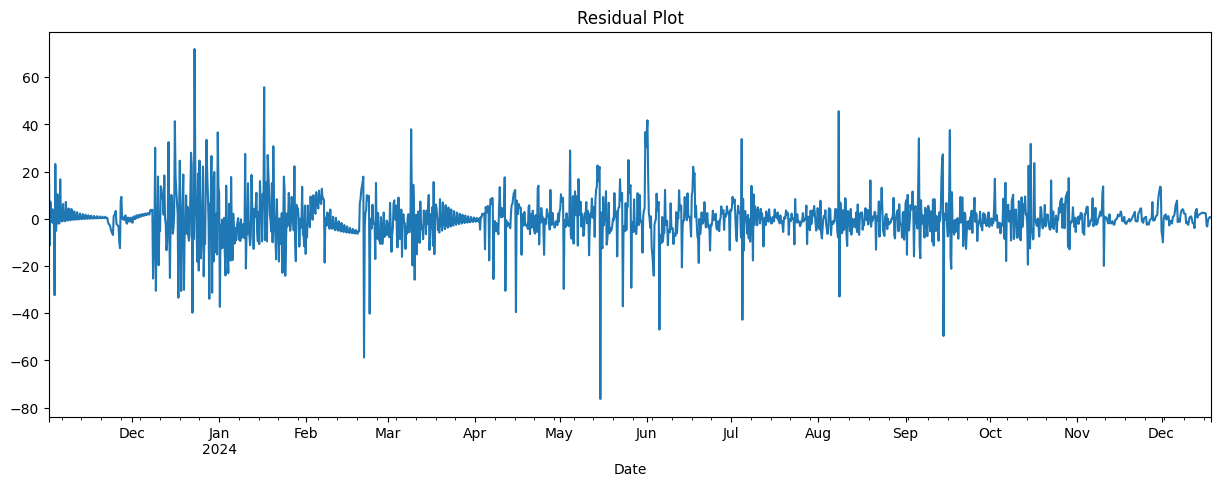

In [11]:
# Residual graph
fig, ax = plt.subplots(figsize = (15, 5))
sarima_result.resid.plot(ax = ax)
plt.title("Residual Plot")
plt.xlabel("Date")
plt.show()

In [ ]:
# Residual Histogram
sarima_result.resid.plot(
    kind = "hist", 
    xlabel = "Residual",
    ylabel = "frequency",
    title = "Residual Distribution"
)

In [12]:
# DataFrame for Actual Test data and Predictions

df_pred_test = pd.DataFrame({
            'y_test':test,
            'y_pred':y_sarima_pred
}, index = test.index)
df_pred_test.tail()

,y_test,y_pred
date,,
2025-03-31 06:00:00+01:00,8.744196,49.601324
2025-03-31 12:00:00+01:00,8.608147,49.608132
2025-03-31 18:00:00+01:00,8.472098,49.642046
2025-04-01 00:00:00+01:00,8.336049,49.620590
2025-04-01 06:00:00+01:00,8.200000,49.599900


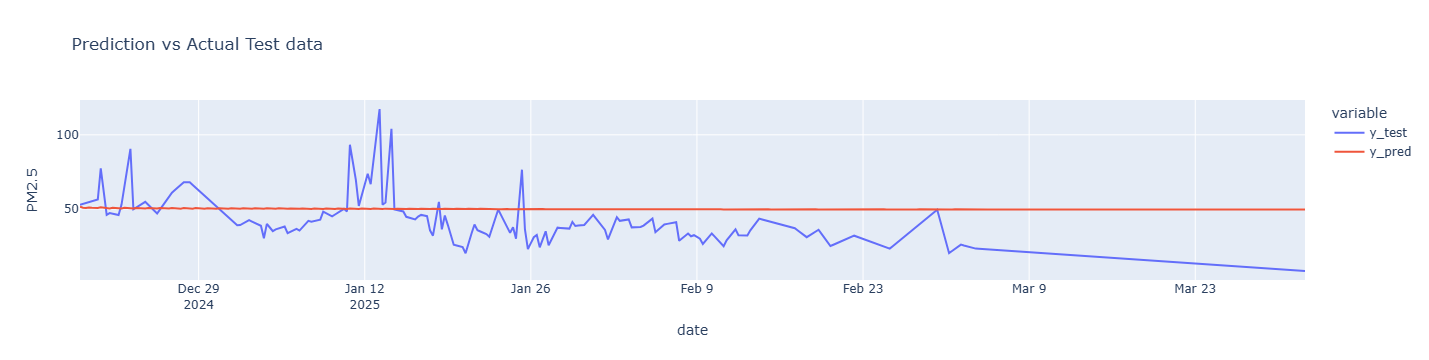

In [13]:
# Plot results
fig = px.line(
    data_frame= df_pred_test,
    title = "Prediction vs Actual Test data ",
    labels= {"value" : "PM2.5"}
)
fig.show()

In [16]:
# Walk Forward Validation

y_pred_wfv = pd.Series()
history = train.copy()
for i in range(len(test)):
     model = SARIMAX(history, order=(3,1,1), seasonal_order=(2,0,2,4)).fit()
     next_pred = model.forecast()
     y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
     history = pd.concat([history, test[next_pred.index]])

# Best model:  ARIMA(3,1,1)(2,0,2)[4]

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\user\AppData\Local\Temp\ipykernel_11184\1977712893.py:8: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users

In [17]:
df_pred_wfv = pd.DataFrame({
            'y_test':test,
            'y_pred':y_pred_wfv
}, index = test.index)
df_pred_wfv.tail()

,y_test,y_pred
date,,
2025-03-31 06:00:00+01:00,8.744196,10.202063
2025-03-31 12:00:00+01:00,8.608147,10.055354
2025-03-31 18:00:00+01:00,8.472098,9.818381
2025-04-01 00:00:00+01:00,8.336049,9.695974
2025-04-01 06:00:00+01:00,8.200000,9.563694


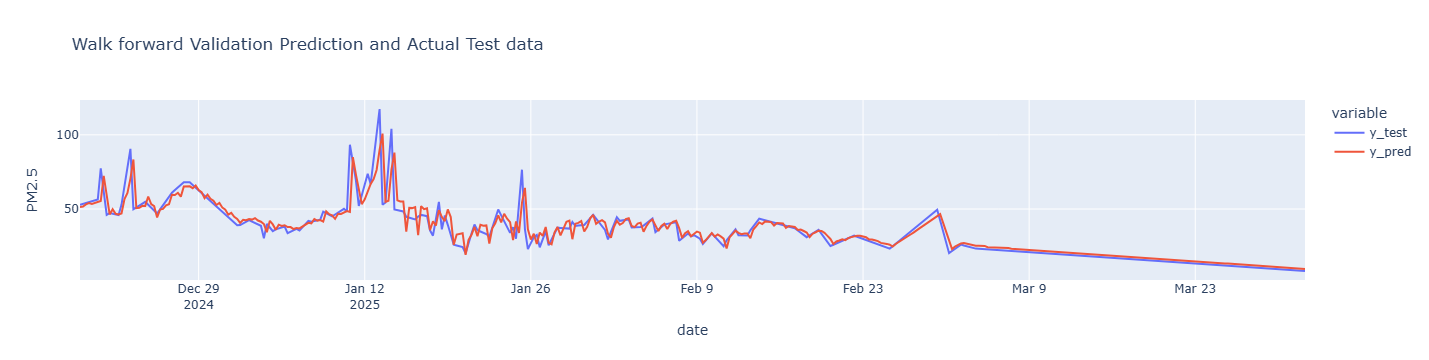

In [18]:
fig = px.line(
    data_frame= df_pred_wfv,
    title = "Walk forward Validation Prediction and Actual Test data",
    labels= {"value" : "PM2.5"}
)

fig.show()

In [19]:
# Evaluation of the Walk forward Validation Prediction

mse = mean_squared_error(test, y_pred_wfv)
mae = mean_absolute_error(test, y_pred_wfv)

print(f"AR Model - MSE: {mse:.2f}")
print(f"AR Model - MAE: {mae:.2f}")

AR Model - MSE: 42.63
AR Model - MAE: 3.44


# Saving Best Performing Model (SARIMA)

- save the model as .pkl
- save the summary log as .txt
- save the work forward validation DataFrame as .csv

In [28]:
# Get current timestamp in ISO format, replacing ':' to avoid file path issues
timestamp = datetime.now().isoformat(timespec='seconds').replace(":", "-")

# Define the result folder (make sure it exists)
result_dir = "../models/"
os.makedirs(result_dir, exist_ok=True)

# Define filenames
model_filename = f"{timestamp}_sarima_model.pkl"
wfv_filename = f"{timestamp}_walk_forward_results.csv"
summary_filename = f"{timestamp}_sarima_summary.txt"

# Save model
joblib.dump(sarima_result, os.path.join(result_dir, model_filename))

# Save walk-forward DataFrame (assuming it's named `wfv_df`)
df_pred_wfv.to_csv(os.path.join(result_dir, wfv_filename), index=True)

# Save model summary
with open(os.path.join(result_dir, summary_filename), "w") as f:
    f.write(str(sarima_result.summary()))


In [5]:
# Get all SARIMA model files
model_files = sorted(glob.glob("../models/*_model.pkl"))

# Model filepaths
filepaths = [file for file in model_files]

# Latest model file
actual = filepaths[-1]

# Load model
model = joblib.load(actual)

# Test model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  PM2.5   No. Observations:                 1654
Model:             SARIMAX(3, 1, 1)x(2, 0, [1, 2], 4)   Log Likelihood               -6002.096
Date:                                Mon, 09 Jun 2025   AIC                          12022.193
Time:                                        10:35:40   BIC                          12070.826
Sample:                                    11-01-2023   HQIC                         12040.228
                                         - 12-18-2024                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8268      0.016     50.277      0.000       0.795       0.859
ar.L2         -0.0364      0.026     -1.397      0.163      -0.087       0.015
ar.L3         -0.0059      0.022     -0.266      0.790      -0.049       0.037
ma.L1         -0.9941      0.004   -268.317      0.000      -1.001      -0.987
ar.S.L4        0.3839      0.139      2.768      0.006       0.112       0.656
ar.S.L8        0.5757      0.136      4.223      0.000       0.309       0.843
ma.S.L4       -0.3306      0.150     -2.202      0.028      -0.625      -0.036
ma.S.L8       -0.4377      0.132     -3.328      0.001      -0.695      -0.180
sigma2        86.9037      1.441     60.319      0.000      84.080      89.727
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7480.19
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                              y_test     y_pred
date                                           
2024-12-19 00:00:00+01:00  52.919605  51.253834
2024-12-19 06:00:00+01:00  53.500504  51.664976
2024-12-19 12:00:00+01:00  54.081404  53.098212
2024-12-19 18:00:00+01:00  54.662303  54.018747
2024-12-20 00:00:00+01:00  55.243202  53.447990


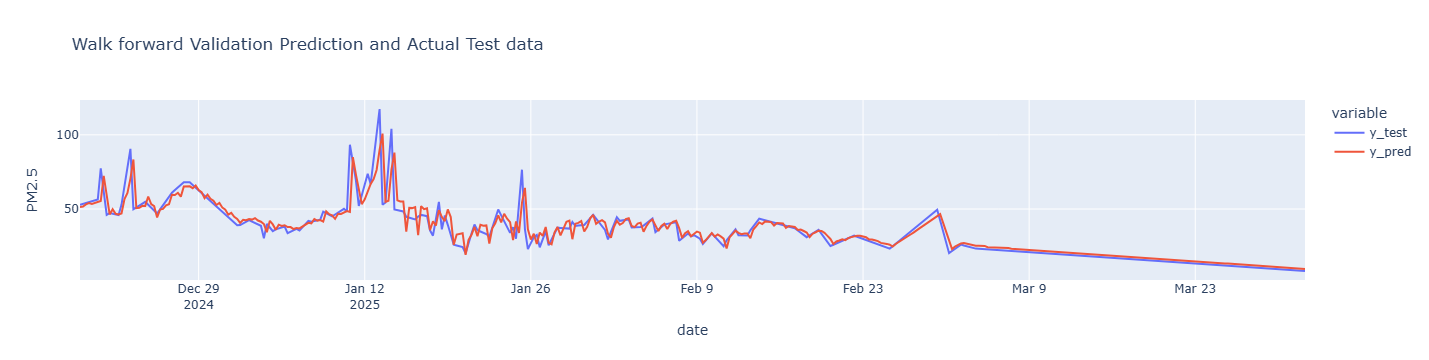

In [24]:
# Load Latest WFV DataFrame
wfv_files = sorted(glob.glob("../models/*_results.csv"))

# CSV filepaths
filepaths = [file for file in wfv_files]

# Latest CSV file
actual = filepaths[-1]

# load csv into DataFrame
wfv_df = pd.read_csv(actual, index_col= "date", parse_dates= True)

print(wfv_df.head())

fig = px.line(
    data_frame= wfv_df,
    title = "Walk forward Validation Prediction and Actual Test data",
    labels= {"value" : "PM2.5"}
)

fig.show()

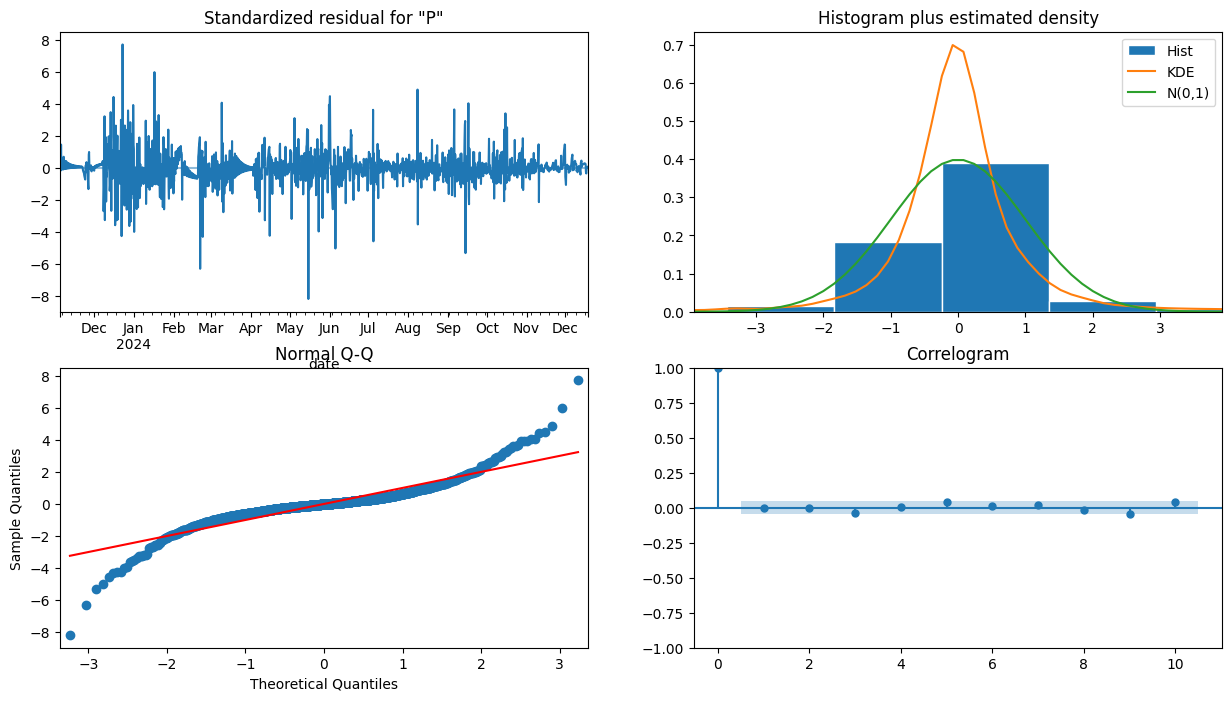

In [25]:
# Check out necessary charts

model.plot_diagnostics(figsize=(15, 8))
plt.show()